# GoogLeNet
2014年ImageNet图象识别挑战赛中，这个网络架构大放异彩。它在NiN的串联网络的思想上做了改进。

这篇论文的重点是解决了**什么样大小的卷积核最合适**的问题。

本文的观点：有时使用不同大小的卷积核组合是有利的

In [ ]:
# 本节实现一个稍微简化的GoogLeNet版本：省略了一些为稳定训练而添加的特殊特性，现在有了更好的训练方法，这些特性不是必要的 

## Inception块
在GoogLeNet中，基本的卷积块叫做Inception块

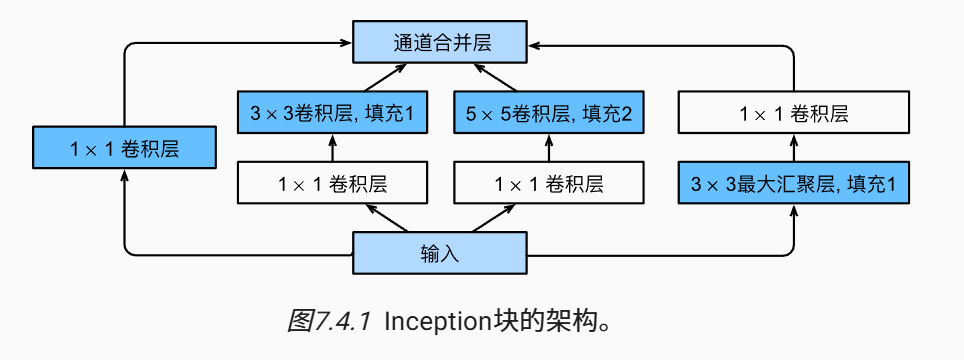

这四条路径都使用合适的填充来使输入与输出的高和宽一致

最后我们将每条线路的输出在通道维度上连结，并构成Inception块的输出。

在Inception块中，通常调整的超参数是每层输出通道数。

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


In [2]:
class Inception(nn.Module):
    # c1-c4是每条路径的输出通道数
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        # 先调用父类的初始化方法
        super(Inception, self).__init__(*kwargs)
        # 线路1，单1*1卷积层
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # 线路2，1*1 + 3*3
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # 线路3，1*1 + 5*5
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # 线路4，maxpooling + 1*1
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # 这里注意maxpooling是same maxpooling，即尺寸不变
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连结输出
        return torch.cat((p1, p2, p3, p4), dim=1)

## GoogLeNet模型
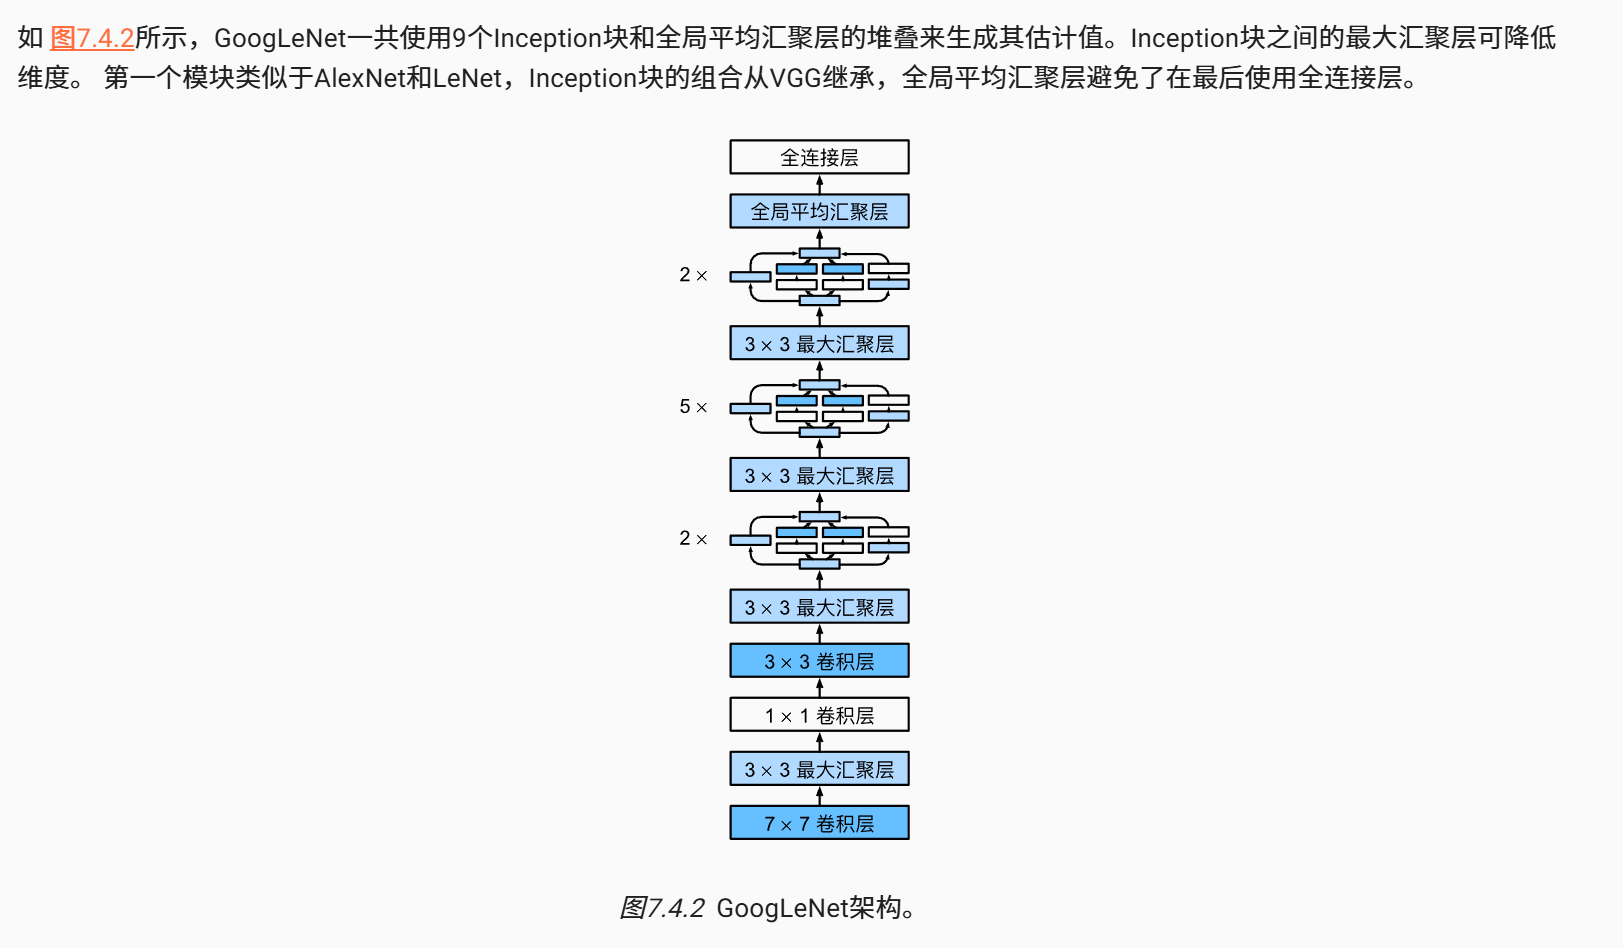
博采众长

In [3]:
# 逐一实现GoogLeNet的每个模块
# 第一个模块使用64通道，7*7卷积
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),  # 尺寸减半
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))  # 尺寸减半


In [4]:
# 第二个模块使用两个卷积层：（1）64个通道、1*1卷积层；（2）通道数量增加三倍的3*3卷积层
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(), 
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))  # 尺寸减半


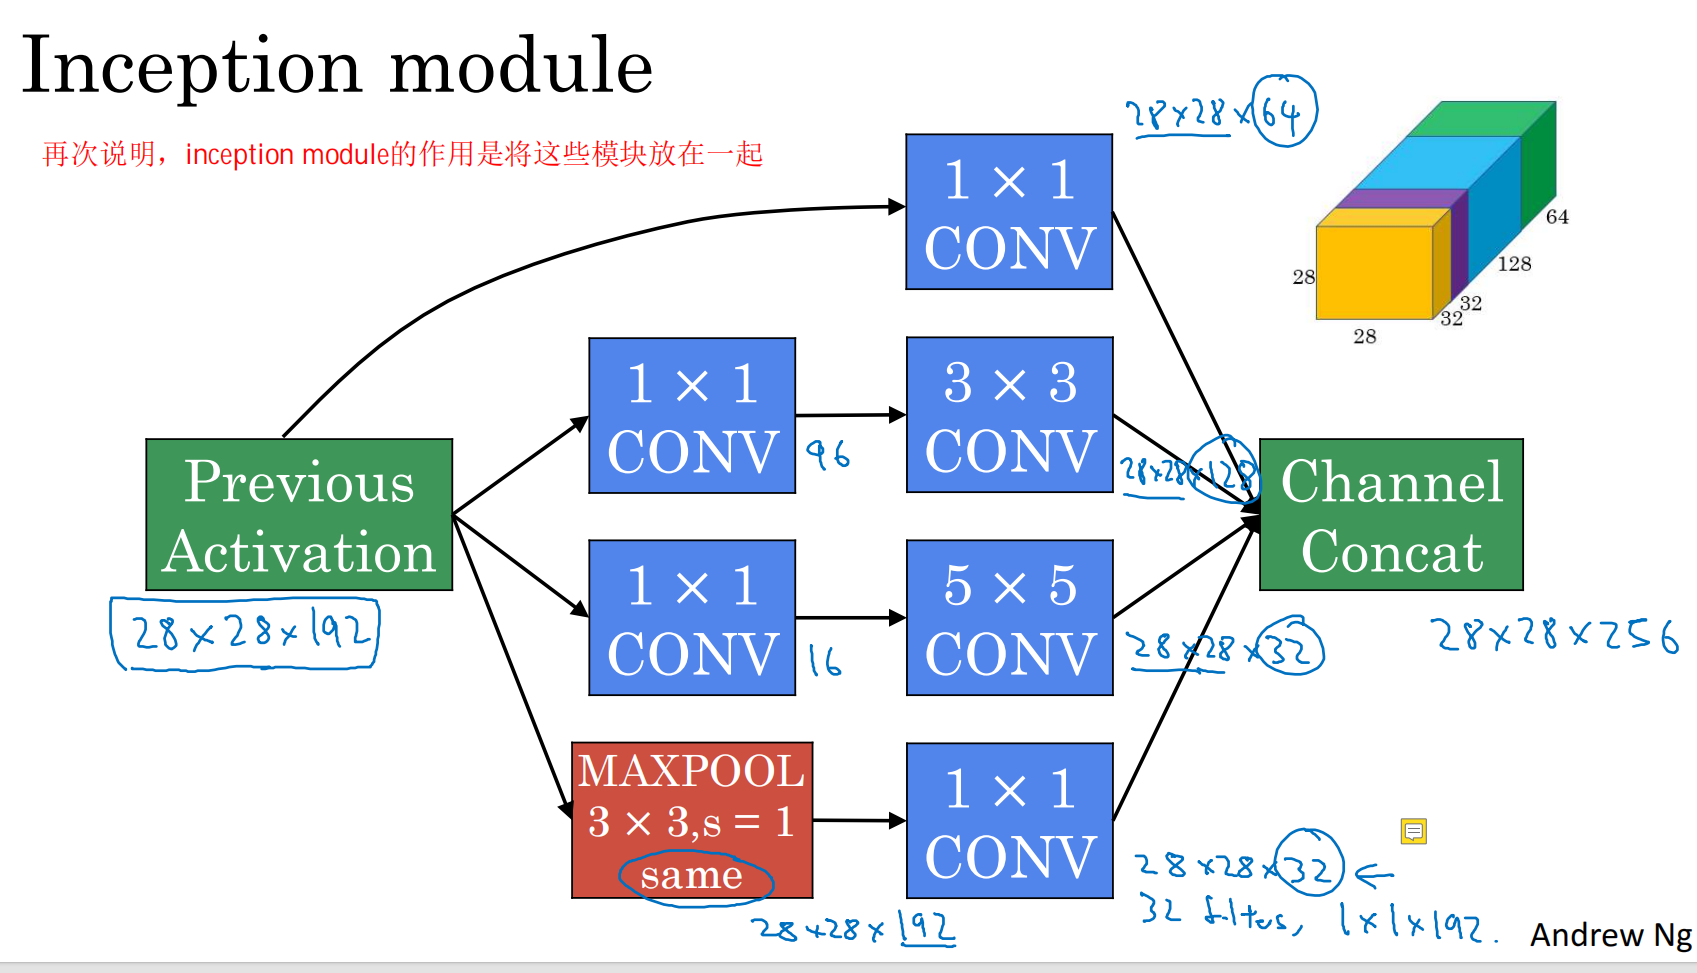

In [5]:
# 第三个模块串联两个完整的inception块
# 如上图所示，第一个Inception块的输出通道数为64+128+32+32=256，
# 四个路径之间的输出通道数量比为64：128：32；32 = 2：4：1：1
# 第二个和第三个路径首先将输入通道的数量分别减少到96/192=1/2，16/192=1/12【bottleneck layer】，然后连接第二个卷积层

# 第二个Inception块的输出通道数增加到128+192+96+64=480
#四个路径之间的输出通道数量比为4：6：3：2
# 第二条和第三条路径首先将输入通道的数量分别减少到128/256 = 1/2，32/256=1/8

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),  # 输出是concat之后的256个通道
                   Inception(256, 128, (128, 192), (32, 96), 64),  # 输出是480个通道
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [6]:
# 第四个模块串联五个Inception块
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128), 
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [7]:
# 第五个模块包含两个Inception块
# 同时第五个模块后面紧跟输出层，该模块同NiN一样使用全局平均汇聚层，将每个通道的高和宽变成1
# 最后将输出变成二维数组，再接上一个输出个数为标签类别数的全连接层

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),  # 384 + 384 + 128 + 128 = 1024
                   nn.AdaptiveAvgPool2d((1, 1)),
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))


In [8]:
# 演示各个模块输出形状变化
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)


Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.310, train acc 0.882, test acc 0.886
1796.9 examples/sec on cuda:0


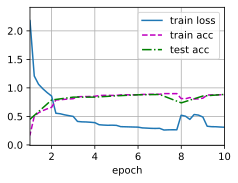

In [9]:
# 训练模型
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())